# Dask

The content of this section is a Jupyter book implementation of [this tutorial](https://github.com/azazel7/BigData-Lab/tree/master/lab3-dask).

**Dask Cluster**</br>
![Dask Cluster](../../figures/dask-cluster.png)

## Installation

To install the complete collection of packages offered by Dask:

```bash
$ pip install "dask[complete]"
```

## Delayed

Delayed functions are lazily evaluated functions (i.e. only evaluated when result is required / when `compute()` is called).

In [1]:
import dask


def inc(x):
    return x + 1

@dask.delayed
def add(x, y):
	return x + y

Or a function can be passed to the `dask.delayed()` function.

In [29]:
x = dask.delayed(inc)(1)
y = dask.delayed(inc)(2)
z = add(x,y)
z

Delayed('add-64158803-4e35-4fc9-8124-fec35433cdf7')

Because `z` is still a delayed object, the `compute()` function needs to be called.

In [30]:
z.compute()

5

The `visualize` function can be used to visualize the graph.

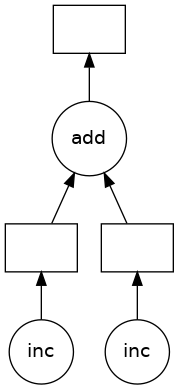

In [31]:
z.visualize()

All Dask objects have a `dask` attribute that stores the calculations necessary to produce the result in a dictionary.

In [32]:
dict(z.dask)

{'add-64158803-4e35-4fc9-8124-fec35433cdf7': (<function __main__.add(x, y)>,
  'inc-0ae34c7f-84dd-4b5e-a214-7d3e2a2851de',
  'inc-7ff3258c-37a0-43d3-beec-403a7b2e2972'),
 'inc-0ae34c7f-84dd-4b5e-a214-7d3e2a2851de': (<function __main__.inc(x)>, 1),
 'inc-7ff3258c-37a0-43d3-beec-403a7b2e2972': (<function __main__.inc(x)>, 2)}

### Important notes

- Not all functions should be delayed. It may be desirable to immediately execute fast functions which allow us to determine which slow functions need to be called.
- Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

In [33]:
import numpy as np


x = dask.delayed(np.arange)(10)
y = (x + 1)[::2].sum()
y.compute()

25

## Array

Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed NumPy.

### Create `dask.array` object

You can create a dask.array Array object with the da.from_array function. This function accepts

- data: Any object that supports NumPy slicing
- chunks: A chunk size to tell us how to block up our array, like (1000000,)

In [34]:
import dask.array as da


x = np.random.rand(100000000) # create random numpy array
y = da.from_array(x, chunks=(1000000,))

### Manipulate `dask.array` objct as you would a `np` array

Now that we have an Array we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc.

In [35]:
y.sum().compute()

49999441.021337554

In [36]:
y[0:4].compute()

array([0.12576971, 0.51197908, 0.91940413, 0.52056526])

### Limitations

`dask.array` does not implement the entire numpy interface. Users expecting this will be disappointed. Notably `dask.array` has the following failings:

- Dask does not implement all of np.linalg. This has been done by a number of excellent BLAS/LAPACK implementations and is the focus of numerous ongoing academic research projects.
- `dask.array` does not support any operation where the resulting shape depends on the values of the array. In order to form the Dask graph we must be able to infer the shape of the array before actually executing the operation. This precludes operations like indexing one Dask array with another or operations like np.where.
- `dask.array` does not attempt operations like sort which are notoriously difficult to do in parallel and are of somewhat diminished value on very large data (you rarely actually need a full sort). Often we include parallel-friendly alternatives like topk.
- Dask development is driven by immediate need, and so many lesser used functions, like np.full_like have not been implemented purely out of laziness. These would make excellent community contributions.

## Bag

Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs. We'll refer to this as "messy" data, because it can contain complex nested structures, missing fields, mixtures of data types, etc. The functional programming style fits very nicely with standard Python iteration, such as can be found in the itertools module.

### Creation

Dask bags can be created from a Python sequence, file, etc.

In [37]:
import dask.bag as db
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=2)
b.take(3)

(1, 2, 3)

### Manipulation

Bag objects hold the standard functional API found in projects like the Python standard library, toolz, or pyspark, including `map`, `filter`, `groupby`, etc.

Operations on Bag objects create new bags. Call the `compute()` method to trigger execution, as we saw for Delayed objects.

In [38]:
def is_even(n):
    return n % 2 == 0

b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
c = b.filter(is_even).map(lambda x: x ** 2)
c

dask.bag<lambda, npartitions=10>

In [39]:
c.compute()

[4, 16, 36, 64, 100]

### GroupBy and FoldBy

Often we want to group data by some function or key. We can do this either with the `groupby` method, which is straightforward but forces a full shuffle of the data (expensive) or with the harder-to-use but faster `foldby` method, which does a streaming combined groupby and reduction.

- `groupby`: Shuffles data so that all items with the same key are in the same key-value pair.
- `foldby`: Walks through the data accumulating a result per key.

Note: the full groupby is particularly bad. In actual workloads you would do well to use foldby or switch to DataFrames if possible.

#### `groupby`

Groupby collects items in your collection so that all items with the same value under some function are collected together into a key-value pair.

In [40]:
b = db.from_sequence(['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank'])
b.groupby(len).compute()  # names grouped by length

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

In [41]:
b = db.from_sequence(list(range(10)))
is_even = lambda x: x % 2
b.groupby(is_even).starmap(lambda k, v: (k, max(v))).compute()

[(0, 8), (1, 9)]

#### `foldby`

When using foldby you provide:

- A key function on which to group elements
- A binary operator such as you would pass to reduce that you use to perform reduction per each group
- A combine binary operator that can combine the results of two reduce calls on different parts of your dataset.

Your reduction must be associative. It will happen in parallel in each of the partitions of your dataset. Then all of these intermediate results will be combined by the combine binary operator.

In [42]:
b.foldby(is_even, binop=max, combine=max).compute()

[(0, 8), (1, 9)]

### Limitations

Bags provide very general computation (any Python function.) This generality comes at cost. Bags have the following known limitations

- Bag operations tend to be slower than array/dataframe computations in the same way that Python tends to be slower than NumPy/Pandas
- Bag.groupby is slow. You should try to use Bag.foldby if possible. Using Bag.foldby requires more thought. Even better, consider creating a normalised dataframe.

## DataFrame

The `dask.dataframe` module implements a blocked parallel DataFrame object that mimics a large subset of the Pandas DataFrame. One Dask DataFrame is comprised of many in-memory pandas DataFrames separated along the index. One operation on a Dask DataFrame triggers many pandas operations on the constituent pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.

In [43]:
import dask.dataframe as dd


# Note: datatypes are inferred by reading the first couple of lines
# and may be incorrect and therefore need to be supplied
df = dd.read_csv('trees.csv',
dtype={"Tree": str, "Park Name": str, "x": np.int8, "y": np.int8})

df.head()

,Tree,Park Name,x,y
0,1,Canada Park,2,3
1,2,Otter Park,63,21
2,3,Canada Park,2,25


In [44]:
len(df)

3

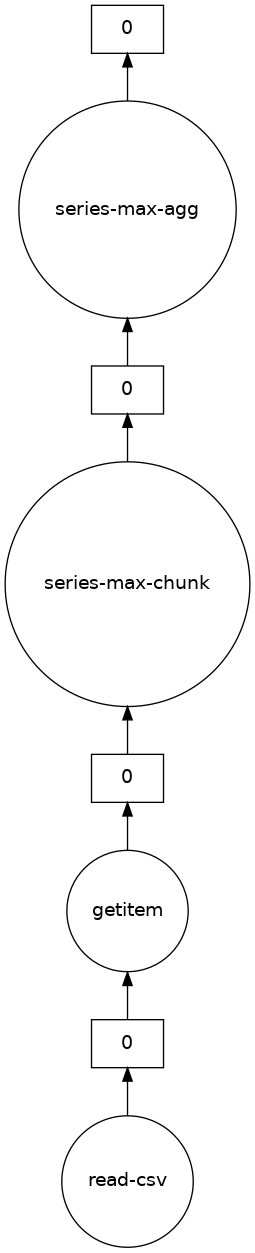

In [45]:
dask.visualize(df.x.max())

### Limitations

Dask.dataframe only covers a small but well-used portion of the Pandas API. This limitation is for two reasons:

- The Pandas API is huge
- Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like set_index work, but are slower than in Pandas because they include substantial shuffling of data, and may write out to disk.